In [172]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Association

In [5]:
stats.uniform().rvs(100)>.61

array([ True, False,  True, False, False,  True,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
        True,  True, False, False,  True,  True, False, False,  True,
       False, False, False,  True,  True,  True, False,  True,  True,
       False,  True, False, False,  True, False, False,  True, False,
       False,  True,  True, False, False,  True, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False,  True, False, False,  True,  True,
       False])

In [69]:
class BookSCM:
    def __init__(self, random_seed = None):
        self.random_seed = random_seed
        self.u_0 = stats.uniform()
        self.u_1 = stats.norm()
        
    def sample(self, sample_size = 100):
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_0 = self.u_0.rvs(sample_size)
        u_1 = self.u_1.rvs(sample_size)
        
        a = u_0 > .61
        b = (a + .5 * u_1) > .2  # 根據 a 的與否，有一定的機率買 b， a, b 相關
        b = u_1 > .8  #  a, b 無相關
        return a,b
            
    

In [70]:
scm = BookSCM(random_seed=45)

In [71]:
buy_book_a, buy_book_b = scm.sample(1000000)

In [72]:
buy_book_a, buy_book_b

# p(buy a|buy b) = P(A and B)/P(B)
# buy_book_a status given buy b is true
buy_book_a[buy_book_b].sum() / len(buy_book_a[buy_book_b])


0.39098487859346315

In [73]:
# P(A and B)
p_a_and_b = (buy_book_a & buy_book_b).sum()/len(buy_book_a)  # 0.37

# P(B)
p_b = buy_book_b.sum()/len(buy_book_b)  # 0.58


# P(A) 
p_a = buy_book_a.sum()/len(buy_book_a)  

# P(A|B) = P(A and B)/P(B)
p_a_and_b / p_b

0.3909848785934632

In [74]:
# if A,B totally independent, then P(A|B) = P(A) 

# 
buy_book_a.sum()/len(buy_book_a)

0.391051

In [75]:
p_b

0.211356

### intervention

In [157]:
np.random.seed(45)

# original
sample_size = 100
u_0 = np.random.randn(sample_size)
u_1 = np.random.randn(sample_size)

a = u_0
b = 5 *a + u_1

r, p = stats.pearsonr(a,b)

print(r,p)
print(a.mean(), a.var())
print(b.mean(), b.var())

0.9776350497880795 3.5878300257959274e-68
-0.1391795389728171 0.8666840196317493
-0.6204932266840709 22.666687799104317


In [158]:
# intervene a
a = np.array([1.5]*sample_size)
b = 5 *a + u_1

r, p = stats.pearsonr(a,b)

print(r,p)
print(a.mean(), a.var())
print(b.mean(), b.var())  

# 假設我們不知道這個模型，就單純藉由 intervention 收集資料
# mean and variance of A and B 改變了，表示 b 因為 a 的改變，而受到了改變
# ther is causal link from A to B

# rp showed nan -> Zero variance in one or both arrays
# 因為 A 沒有 variance，所以無法表達出 covary of A and B
# Correlation drops to near zero because  A  is constant (no variability), so it cannot covary with  B .

nan nan
1.5 0.0
7.575404468180015 1.0025411156718493


In [159]:
# intervene b
a = u_0
b = np.random.randn(sample_size)

r, p = stats.pearsonr(a,b)

print(r,p)
print(a.mean(), a.var())
print(b.mean(), b.var())

# Correlation drop to near zero, because  B  is now independent of  A . 
# Intervening on  B  does not affect  A .
# A 的 mean 以及 variance 沒有因為 B 的改變而改變

# 表示 no causal link from  B  to  A .

-0.02286603910467949 0.82134525059407
-0.1391795389728171 0.8666840196317493
0.18551970084448796 0.9949738521691471


In [141]:
scm2 = BookSCM2(45)

In [142]:
a, b = scm2.sample(100) 

In [143]:
r, p  = stats.pearsonr(a,b)
r

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


nan

In [125]:
b.var()

1.0025411156718493

# Correlation and causation

In [170]:
sample_size = 100000
x = np.random.uniform(-2,2,sample_size)  # x~U(-2,2)
y = x*x + 0.2 * np.random.normal(0,1,sample_size)

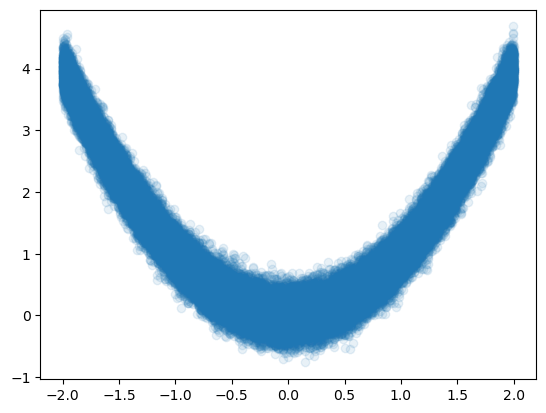

In [174]:
plt.scatter(x,y,alpha=.1)

In [176]:
stats.pearsonr(x,y)  # pearson correlation = 0

PearsonRResult(statistic=0.006680012619176792, pvalue=0.03465192980488826)

# Counterfactuals

In [191]:
# model
# T ~ t
# Y ~ TU + (T-1)(U-1)

class CounterFac:
    def abduct(self, t, y):
        # from observed y and known t, get u
        u = (y+t-1)/(2*t-1)
        return u
    
    def modify(self, t):
        # return model under counterfactual status 
        return lambda u: t*u + (t-1)*(u-1)
    
    def predict(self, t, u):
        return self.modify(t)(u)
    
    


In [198]:
coffee = CounterFac()
u = coffee.abduct(1,1)  # get u value
coffee.predict(t=0,u=u)  # undeer t=0 status, get the y value when u=u


0.0

# Linear regression

In [230]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.random.seed(45)
n_samples = 5000

In [220]:
alpha = 1.12
beta = 0.93
epsilon = np.random.normal(size=n_samples)
# epsilon = np.random.normal(n_samples)  # the same

In [221]:
np.random.randn(n_samples)

array([ 0.11530002, -0.43617719, -0.54138887, ..., -0.03732549,
       -0.23686068, -1.79838402])

In [224]:
# data generating process
X = np.random.normal(size=n_samples)
y = alpha + beta*X + 0.5*epsilon


In [232]:
X_add_constant = sm.add_constant(X)  # add constant
model = sm.OLS(y, X_add_constant)
fitted_model = model.fit()

In [236]:
# predicted y
y_predicted = fitted_model.predict(X_add_constant)

In [233]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.718e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        02:53:04   Log-Likelihood:                -3615.7
No. Observations:                5000   AIC:                             7235.
Df Residuals:                    4998   BIC:                             7248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1244      0.007    159.401      0.000       1.111       1.138
x1             0.9319      0.007    131.083      0.000       0.918       0.946
==============================================================================
Omnibus:                        0.108   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.139
Skew:                           0.003   Prob(JB):                        0.933
Kurtosis:                       2.975   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

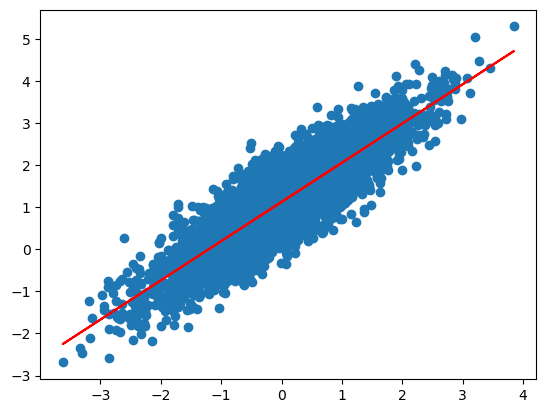

In [238]:
plt.scatter(X,y)
plt.plot(X,y_predicted, c='red')

In [245]:
# regress X on Y

y_add_constant = sm.add_constant(y)

# create model
model = sm.OLS(X, y_add_constant).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.718e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        03:46:34   Log-Likelihood:                -3330.0
No. Observations:                5000   AIC:                             6664.
Df Residuals:                    4998   BIC:                             6677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9341      0.010    -95.628      0.000      -0.953      -0.915
x1             0.8313      0.006    131.083      0.000       0.819       0.844
==============================================================================
Omnibus:                        1.532   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.465   Jarque-Bera (JB):                1.480
Skew:                          -0.038   Prob(JB):                        0.477
Kurtosis:                       3.038   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
x_predicted = model.predict(y_add_constant)  # predicted x

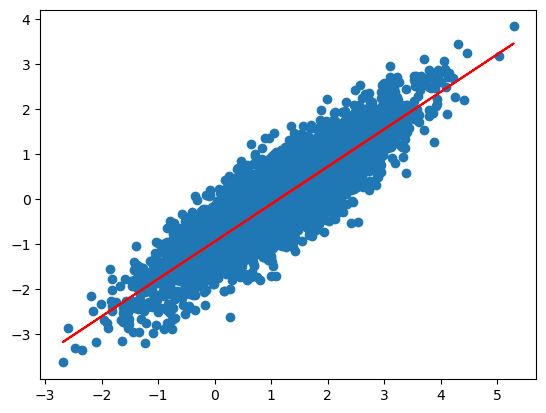

In [250]:
# plot
plt.scatter(y, X)
plt.plot(y, x_predicted, c='r')

In [284]:
# control example, P46

a = np.random.normal(size=n_samples)
x = 2*a + 0.5*np.random.normal(size=n_samples)
y = 2*a + 0.5*np.random.normal(size=n_samples)
b = 1.5*x + 0.75*y

In [298]:
variants = [
    [x],
    [x,a],
    [x,b],
    [x,a,b]
]

# fit iteratively

for variant in variants:
    X_constant = sm.add_constant(np.stack(variant).transpose())
    model = sm.OLS(y,X_constant).fit()
    print(model.summary2())
    print('\n\n')
    
    

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.884     
Dependent Variable: y                AIC:                10466.6185
Date:               2024-11-04 05:48 BIC:                10479.6528
No. Observations:   5000             Log-Likelihood:     -5231.3   
Df Model:           1                F-statistic:        3.826e+04 
Df Residuals:       4998             Prob (F-statistic): 0.00      
R-squared:          0.884            Scale:              0.47476   
----------------------------------------------------------------------
         Coef.     Std.Err.       t        P>|t|      [0.025    0.975]
----------------------------------------------------------------------
const    0.0105      0.0097      1.0759    0.2820    -0.0086    0.0296
x1       0.9447      0.0048    195.5916    0.0000     0.9352    0.9541
-------------------------------------------------------------------
Omnibus:                1.143        Durbin-Watson:

In [295]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     1.000       
Dependent Variable: y                AIC:                -319397.0430
Date:               2024-11-04 05:48 BIC:                -319370.9743
No. Observations:   5000             Log-Likelihood:     1.5970e+05  
Df Model:           3                F-statistic:        6.467e+32   
Df Residuals:       4996             Prob (F-statistic): 0.00        
R-squared:          1.000            Scale:              1.0585e-29  
---------------------------------------------------------------------
        Coef.  Std.Err.           t            P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const  -0.0000   0.0000                -3.8450 0.0001 -0.0000 -0.0000
x1     -2.0000   0.0000 -9627170873520990.0000 0.0000 -2.0000 -2.0000
x2      0.0000   0.0000                25.8093 0.0000  0.0000  0.0000
x3      1.3333   0.0000 10872742365546304.0000 0.0000  1.3333  1.3333
---------------------------------------------------------------------
Omnibus:                8.098         Durbin-Watson:            2.062
Prob(Omnibus):          0.017         Jarque-Bera (JB):         8.300
Skew:                   0.076         Prob(JB):                 0.016
Kurtosis:               3.129         Condition No.:            33   
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [290]:
np.stack([x,a]).transpose() # stack在一起後，要從 X1-1,X1-2,X1-3 轉為一個一個的 X1-1,X2-1,X3-1

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [283]:
a = [[1,2,3],  # shape = (2,3)
     [4,5,6]]
b = [[7,8,9],
     [10,11,12]]
np.stack([a,b],axis=0)
# 新的 array 的 shape 為 (2[new],2,3)
# 在 array axis 0 新增一個位置，等待 b 的部分來填充，原本的 axis 0之後都升級
# a = [[1,2,3], 
#     [4,5,6]] 變成 
# a = [[[1,2,3], 
#     [4,5,6]], 等待b的部分]

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

In [282]:
np.stack([a,b],axis=1) 
# 新的 array 的 shape 為 (2,2[new],3)
# 在 array axis 1 新增一個位置，等待 b 的部分來填充，原本的 axis 1之後都升級
# a = [[1,2,3], 
#     [4,5,6]] 變成 
# a = [[[1,2,3],等待b的部分], 
#     [[4,5,6]],等待b的部分] 


array([[[ 1,  2,  3],
        [ 7,  8,  9]],

       [[ 4,  5,  6],
        [10, 11, 12]]])

In [279]:
np.stack([a,b],axis=2)
# 新的 array 的 shape 為 (2,3,2[new])
# 在 array axis 2 新增一個位置，等待 b 的部分來填充，原本的 axis 2之後都升級
# a = [[1,2,3], 
#     [4,5,6]] 變成 
# a = [[1,等待b的部分],[2,等待b的部分],[3,等待b的部分],
#     [[4,等待b的部分],[5,等待b的部分],[6,等待b的部分]]

array([[[ 1,  7],
        [ 2,  8],
        [ 3,  9]],

       [[ 4, 10],
        [ 5, 11],
        [ 6, 12]]])

In [260]:
sm.OLS(y,x.transpose()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.884
Method:                 Least Squares   F-statistic:                          3.806e+04
Date:                Mon, 04 Nov 2024   Prob (F-statistic):                        0.00
Time:                        04:44:43   Log-Likelihood:                         -5263.6
No. Observations:                5000   AIC:                                  1.053e+04
Df Residuals:                    4999   BIC:                                  1.054e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9343      0.005    195.102      0.000       0.925       0.944
==============================================================================
Omnibus:                        0.041   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.980   Jarque-Bera (JB):                0.058
Skew:                           0.005   Prob(JB):                        0.972
Kurtosis:                       2.987   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""